<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
    
<h1 style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:150%"><b> Table of contents </b></h1>

 - [**Introduction**](#1)

 - [**Explore**](#2)
 
 - [**Pre-processing and feature selection**](#3)
    
 - [**Modelling and Evaluation**](#4)
    - [**Logistical Classification**](#4_1)
    - [**Decision Tree**](#4_3)
    - [**Random Forest**](#4_5)
    - [**Gradient Boosting Classifier**](#4_6)
    - [**Neural Network MLP**](#4_7)
    
 - [**Evaluate**](#5)
 - [**Conclusion**](#6)
   

<a id='1'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Introduction</b>

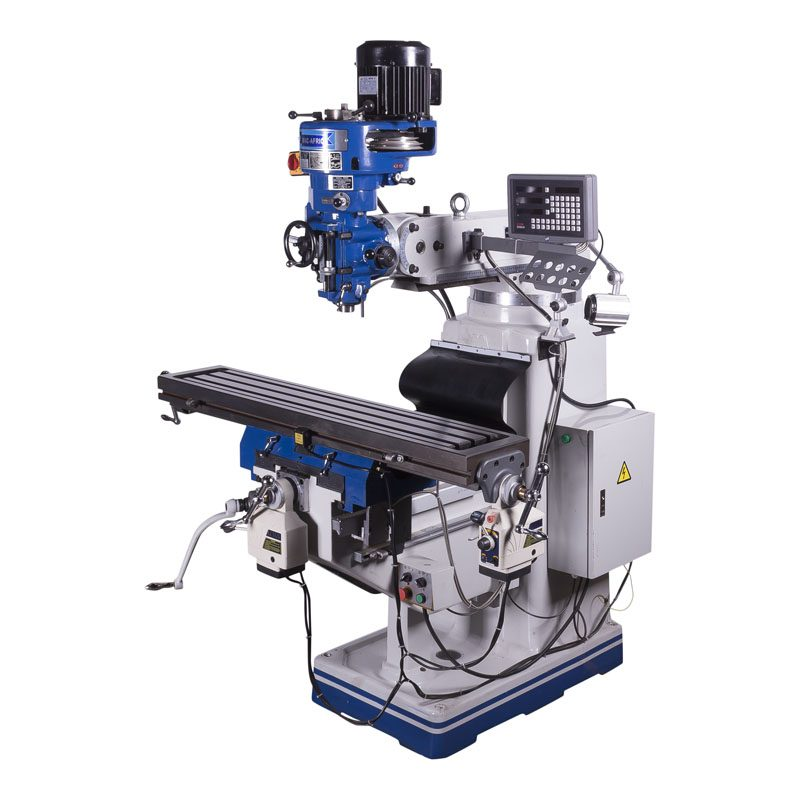

This synthetic dataset is modeled after an existing milling machine and consists of 10 000 data points from a stored as rows with 14 features in columns

1. UID: unique identifier ranging from 1 to 10000
2. product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
3. type: just the product type L, M or H from column 2
4. air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
5. process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
6. rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
7. torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
8. tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
9. a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes

1. tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
2. heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.
3. power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
4. overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
5. random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.
This dataset is part of the following publication, please cite when using this dataset:
S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.

The image of the milling process is the work of Daniel Smyth @ Pexels: https://www.pexels.com/de-de/foto/industrie-herstellung-maschine-werkzeug-10406128/

<a id='2'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Explore</b>

In [ ]:
pip install plotly seaborn matplotlib ipython scikit-learn statsmodels imblearn pandas_profiling -q

In [1]:
import numpy as np
import pandas as pd

from IPython.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio


import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings

# Configure Jupyter Notebook
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

reload(plt)
%matplotlib inline
%config InlineBackend.figure_format ='retina'

warnings.filterwarnings('ignore')

# configure plotly graph objects
pio.renderers.default = 'iframe'
# pio.renderers.default = 'vscode'

pio.templates["ck_template"] = go.layout.Template(
    layout_colorway = px.colors.sequential.Viridis, 
#     layout_hovermode = 'closest',
#     layout_hoverdistance = -1,
    layout_autosize=False,
    layout_width=800,
    layout_height=600,
    layout_font = dict(family="Calibri Light"),
    layout_title_font = dict(family="Calibri"),
    layout_hoverlabel_font = dict(family="Calibri Light"),
#     plot_bgcolor="white",
)
 
# pio.templates.default = 'seaborn+ck_template+gridon'
pio.templates.default = 'ck_template+gridon'
# pio.templates.default = 'seaborn+gridon'
# pio.templates

In [2]:
df = pd.read_csv('./data/ai4i2020.csv')
# df = pd.read_csv('ai4i2020.csv')

First up is just to eyeball the data. It seems that there are two indices: the index and ProductID. We can drop those. There is a Type which is categorical and the remainder are numeric. The last five feastures are all failure modes, so they will not be evaluated in this notebook. 

In [3]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [ ]:
# Generate a new CSV with twice the failure frequency for better visualization in the app
df2 = df[df['Machine failure'] == 1]
df3 = df[df['Machine failure'] == 0]
df4 = pd.concat([df2] + [df3.sample(n=len(df2)*2, random_state=42)])  # downsample normal operation data for visualization
df4.shape
df4.to_csv('./data/twice_freq.csv', index=False)

There are no apparent missing values, but we'll check these out carefully to make sure

In [ ]:
df.info()

In [ ]:
df.describe(include='all').T

making sure that there are no missing values hidden as a question mark

In [ ]:
df.replace("?",np.nan,inplace=True)

turn all columns into float to make processing later easier

In [ ]:
for column in df.columns:
    try:
        df[column]=df[column].astype(float)
    except:
        pass

just check the descriptions for the numeric features. None missing and on apparent outliers

In [ ]:
# show the numeric characters
df_numeric = df.select_dtypes(include=[np.number])
df_numeric.describe(include='all').T

Another verification whether there are any missing features. I see none. 

In [ ]:
plt.figure(figsize=(15,15))
plot_kws={"s": 1}
sns.heatmap(df.isna().transpose(),
            cmap='cividis',
            linewidths=0.0,
           ).set_facecolor('white')

There are strongly correlated features namely process and air temperature. Torque and rotational speed are also strongly correlated. We can drop one of the temperatures, but the torque to rotational speed difference might be a indication of a failure, so we'll keep both.  

In [ ]:
plt.figure(figsize=(10,10))
threshold = 0.80
sns.set_style("whitegrid", {"axes.facecolor": ".0"})
df_cluster2 = df.corr()
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()
plot_kws={"s": 1}
sns.heatmap(df_cluster2,
            cmap='RdYlBu',
            annot=True,
            mask=mask,
            linewidths=0.2, 
            linecolor='lightgrey').set_facecolor('white')

In [ ]:
from pandas_profiling import ProfileReport

The profiling report follows to look for outliers, missing values, and distributions. We can see that the data is imbalanced. 

In [ ]:
%%time
profile = ProfileReport(df,
                        title="Predictive Maintenance",
                        dataset={"description": "This profiling report was generated for Carl Kirstein",
                                 "copyright_holder": "Carl Kirstein",
                                 "copyright_year": "2022",
                                },
                        explorative=True,
                       )
profile

Drop the indices as these have no predictive power

In [ ]:
df.drop(['UDI','Product ID'],axis=1,inplace=True)

Drop the failure modes, as we're only interested whether something is a failure. I guess that you'll build a model for each failure mode if it comes down to that.

In [ ]:
df.drop(['TWF','HDF','PWF','OSF','RNF'],axis=1,inplace=True)

Drop the type, as this dominates too strongly on type = L.

In [ ]:
df.drop(['Type'],axis=1,inplace=True)

The remaining features

In [ ]:
list(df)

turn categorical information into numeric 

In [ ]:
df = pd.get_dummies(df,drop_first=True)

In [ ]:
features = list(df.columns)

In [ ]:
for feature in features:
    print(feature + " - " + str(len(df[df[feature].isna()])))

Just another confirmation of how badly imbalanced the data is. We'll need to oversample in this case to get a better prediction.

In [ ]:
df_group = df.groupby(['Machine failure'])
df_group.count()

In [ ]:
df[df['Machine failure'].isna()]

<a id='3'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Pre-processing and Feature Selection</b>

replace the missing numeric values with the mean

In [ ]:
df_numeric.fillna(df_numeric.mean(),inplace=True)

for feature in features:
    try:
        df[feature].fillna(df[feature].mean(),inplace=True)
    except:
        try:
            df[feature].fillna(df[feature].mode(),inplace=True)
        except:
            pass

In [ ]:
df.describe(include='all').T

Perform a statistical univariate test to determine the best features. Product type L dominates this strongly.

In [ ]:
# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

best_features = SelectKBest(score_func=chi2,k='all')

X = df.iloc[:,:-1]
y = df.iloc[:,-1]
fit = best_features.fit(X,y)

df_scores=pd.DataFrame(fit.scores_)
df_col=pd.DataFrame(X.columns)

feature_score=pd.concat([df_col,df_scores],axis=1)
feature_score.columns=['feature','score']
feature_score.sort_values(by=['score'],ascending=True,inplace=True)

fig = go.Figure(go.Bar(
            x=feature_score['score'][0:21],
            y=feature_score['feature'][0:21],
            orientation='h'))

fig.update_layout(title="Top 20 Features",
                  height=1200,
                  showlegend=False,
                 )

fig.show()

In [ ]:
# awesome bit of code from https://www.kaggle.com/code/adibouayjan/house-price-step-by-step-modeling

Selected_Features = []
import statsmodels.api as sm

def backward_regression(X, y, initial_list=[], threshold_out=0.5, verbose=True):
    """To select feature with Backward Stepwise Regression 

    Args:
        X -- features values
        y -- target variable
        initial_list -- features header
        threshold_out -- pvalue threshold of features to drop
        verbose -- true to produce lots of logging output

    Returns:
        list of selected features for modeling 
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")


# Application of the backward regression function on our training data
backward_regression(X, y)

In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [ ]:
X.head()
feature_names = list(X.columns)
np.shape(X)

In [ ]:
np.shape(X)

In [ ]:
len(feature_names)

<a id='4'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Modelling and Evaluation</b>

The data is too imbalanced, therefore we usually oversample. The randomoversampler performs better than SMOTE, but not oversampling performs the best. This is curious, but there are studies (check my discussion here: https://www.kaggle.com/competitions/autismdiagnosis/discussion/322588) that reckon that it is better not to oversample.

In [ ]:
!pip install imblearn
# import library
from imblearn.over_sampling import SMOTE, SVMSMOTE,RandomOverSampler
oversamp = RandomOverSampler(random_state=0)
# oversamp = SMOTE(n_jobs=-1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0,
                                                    stratify=y)
# X_train,y_train = oversamp.fit_resample(X_train, y_train)

There are no distinct outliers, therefore a simple minmax scaler suffices. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
import joblib
joblib.dump(sc, "scaler.joblib")

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,roc_auc_score, plot_confusion_matrix,matthews_corrcoef
from sklearn.metrics import plot_confusion_matrix # will plot the confusion matrix

import time
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','MCC score','time to train','time to predict','total time'])


<a id='4_1'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>Logistical Classification</b>

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression
start = time.time()
model = LogisticRegression().fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

In [ ]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Logistic'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

In [ ]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

<a id='4_3'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>Decision Tree</b>

In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier
start = time.time()
model = DecisionTreeClassifier().fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

In [ ]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Decision Tree'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

In [ ]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

In [ ]:
plt.rcParams['figure.figsize']=10,10
sns.set_style("white")
feat_importances = pd.Series(model.feature_importances_, index=feature_names)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

<a id='4_5'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>Random Forest</b>

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
start = time.time()
model = RandomForestClassifier(n_estimators = 100,n_jobs=-1,random_state=0,bootstrap=True,).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

In [ ]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Random Forest'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

In [ ]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

<a id='4_6'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>Gradient Boosting Classifier</b>

In [ ]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
start = time.time()
model = GradientBoostingClassifier().fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

In [ ]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Gradient Boosting Classifier'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

In [ ]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

In [ ]:
plt.rcParams['figure.figsize']=10,10
sns.set_style("white")
feat_importances = pd.Series(model.feature_importances_, index=feature_names)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

<a id='4_7'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>Neural Network MLP</b>

In [ ]:
%%time
from sklearn.neural_network import MLPClassifier
start = time.time()
model = MLPClassifier(hidden_layer_sizes = (100,100,), 
                      activation='relu', 
                      solver='adam',
                      batch_size=2000,
                      verbose=0).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

In [ ]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions, average='weighted')
precision = precision_score(y_test, y_predictions, average='weighted')
f1s = f1_score(y_test, y_predictions, average='weighted')
MCC = matthews_corrcoef(y_test, y_predictions)
# ROC_AUC = roc_auc_score(y_test, y_predictions, average='weighted')
ROC_AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average='weighted')

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("MCC: "+ "{:.2%}".format(MCC))
print("ROC AUC score: "+ "{:.2%}".format(ROC_AUC))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Neural Network MLP'] = [accuracy, recall, precision, f1s,MCC,end_train-start,end_predict-end_train,end_predict-start]

In [ ]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

<a id='5'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Evaluate</b>

In [ ]:
model_performance.fillna(.90,inplace=True)
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'MCC score': '{:.2%}',
                                                                     'time to train':'{:.1f}',
                                                                     'time to predict':'{:.1f}',
                                                                     'total time':'{:.1f}',
                                                                     })

<a id='6'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Conclusion</b>

The bulk of the prediction lays with the type Product L that strongly suggests a failure. This however only gave a 90% accuracy. I dropped the type and got much more accurate results as a result. Random forest seems to be the go-to model for this case, giving even a decent MCC score. 

don't forget to upvote if you found this useful.